In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasRandomSearch, KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
### READ DATA ###

df = pd.read_csv('AirQualityUCI.csv', sep=';', parse_dates={'date':['Date', 'Time']})
df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)

df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')
date = df['date'].values
df.set_index('date', inplace=True)

df.columns = [col.split('(')[0] for col in df.columns]

print(df.shape)
df.head()

(9357, 13)


,CO,PT08.S1,NMHC,C6H6,PT08.S2,NOx,PT08.S3,NO2,PT08.S4,PT08.S5,T,RH,AH
date,,,,,,,,,,,,,
2004-03-10 18:00:00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
2004-03-10 19:00:00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2004-03-10 20:00:00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
2004-03-10 21:00:00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
2004-03-10 22:00:00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [3]:
### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

CO : 0.17986534145559474
PT08.S1 : 0.0391151009939083
NMHC : 0.9023191193758683
C6H6 : 0.0391151009939083
PT08.S2 : 0.0391151009939083
NOx : 0.17516297958747462
PT08.S3 : 0.0391151009939083
NO2 : 0.1754835951693919
PT08.S4 : 0.0391151009939083
PT08.S5 : 0.0391151009939083
T : 0.0391151009939083
RH : 0.0391151009939083
AH : 0.0391151009939083


In [4]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [5]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
df_external['hour'] = df_external.date.dt.hour

df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(9357, 9)


,T,RH,AH,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
date,,,,,,,,,
2004-03-10 18:00:00,13.6,48.9,0.7578,1.0,6.123234e-17,0.866025,-0.5,-0.979084,0.203456
2004-03-10 19:00:00,13.3,47.7,0.7255,1.0,6.123234e-17,0.866025,-0.5,-0.887885,0.460065
2004-03-10 20:00:00,11.9,54.0,0.7502,1.0,6.123234e-17,0.866025,-0.5,-0.730836,0.682553
2004-03-10 21:00:00,11.0,60.0,0.7867,1.0,6.123234e-17,0.866025,-0.5,-0.519584,0.854419
2004-03-10 22:00:00,11.2,59.6,0.7888,1.0,6.123234e-17,0.866025,-0.5,-0.269797,0.962917


In [6]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(df, shuffle=False, train_size=0.8)
train_ext, test_ext = train_test_split(df_external, shuffle=False, train_size=0.8)

print(train.shape, test.shape)
print(train_ext.shape, test_ext.shape)

(7485, 9) (1872, 9)
(7485, 9) (1872, 9)


In [7]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

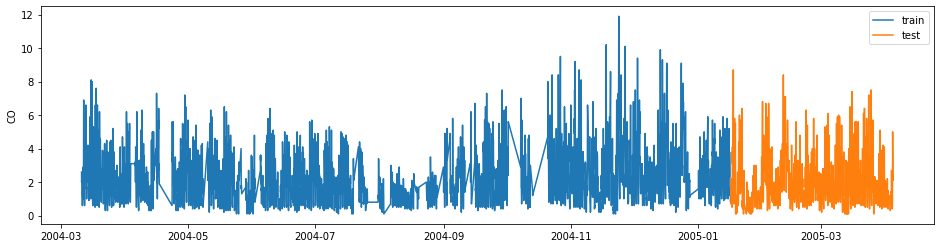

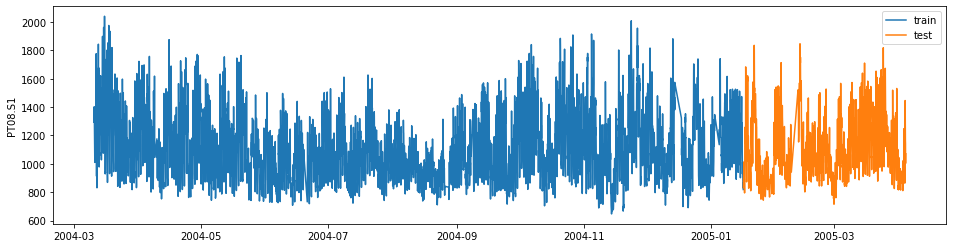

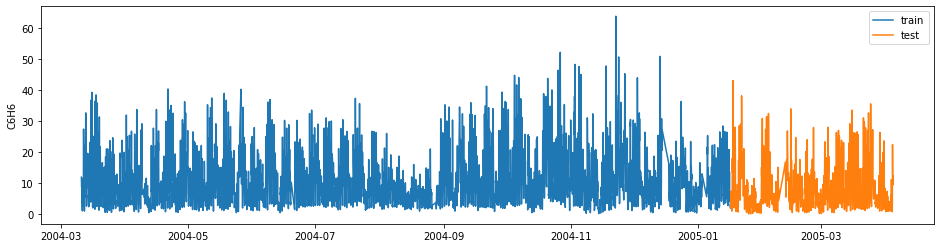

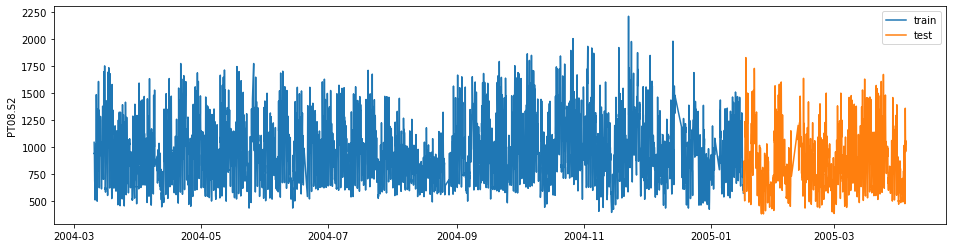

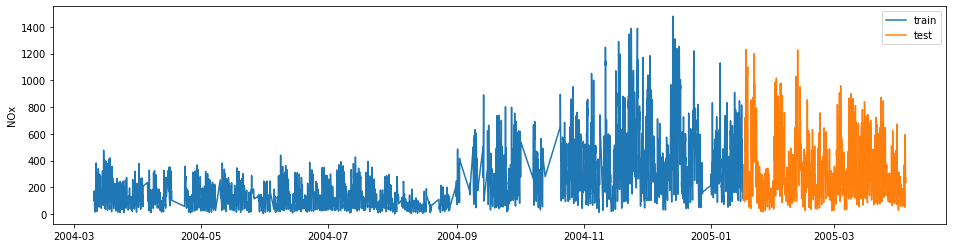

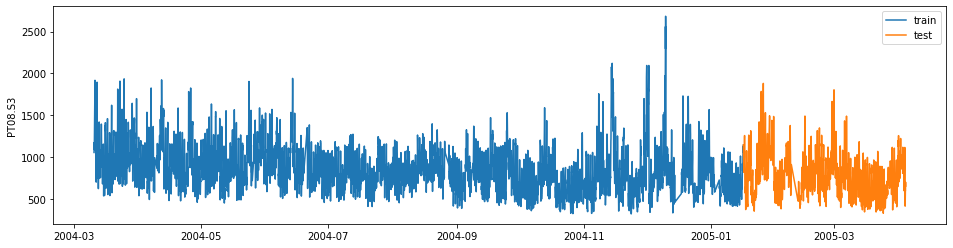

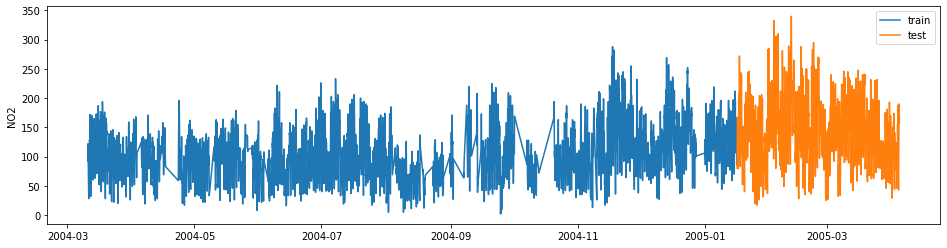

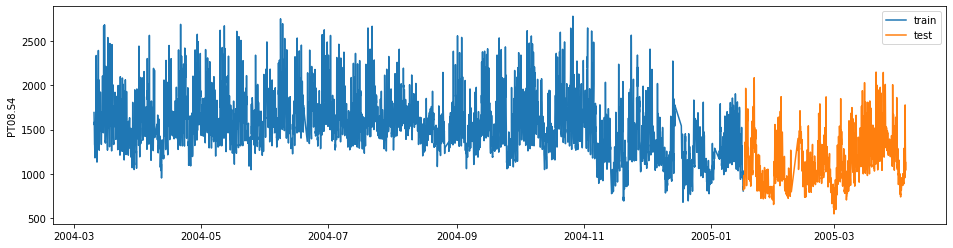

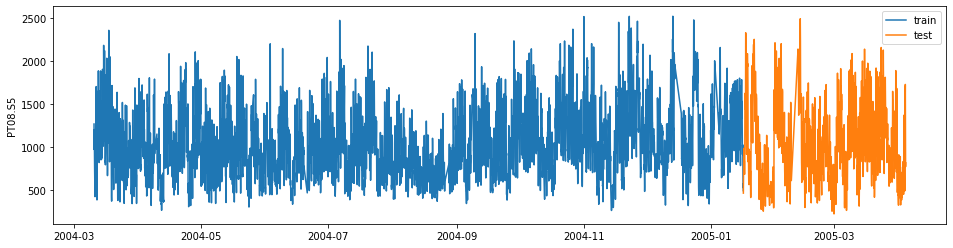

In [8]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

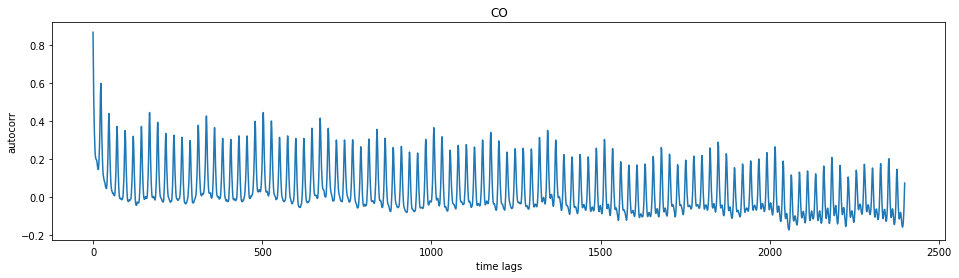

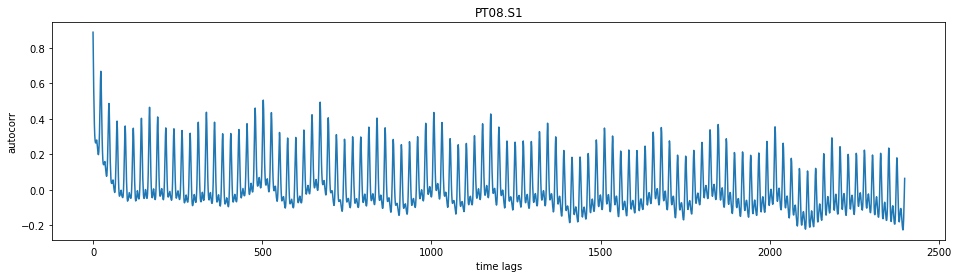

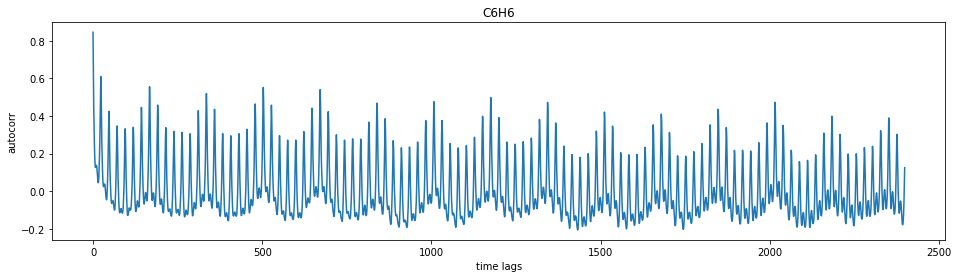

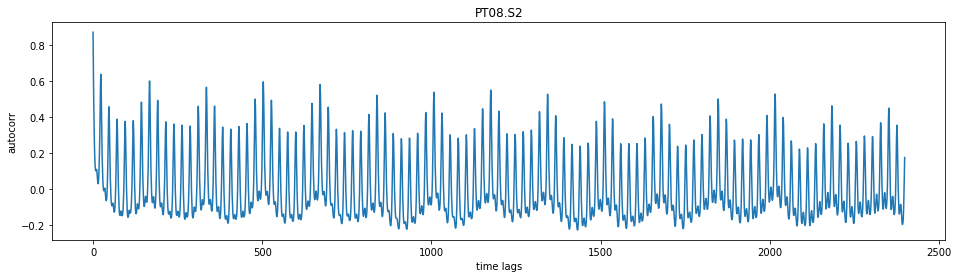

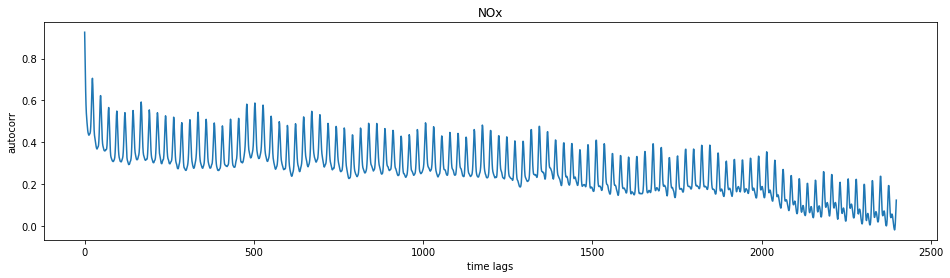

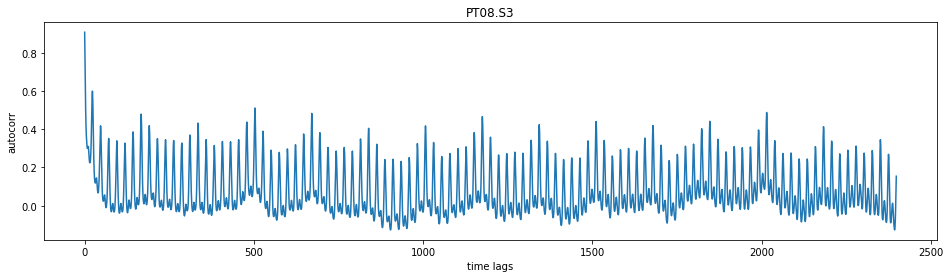

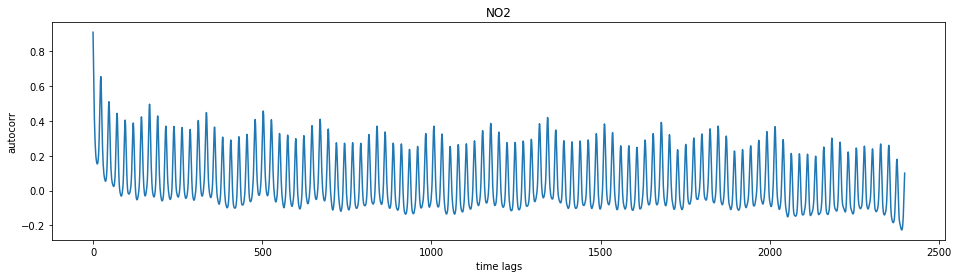

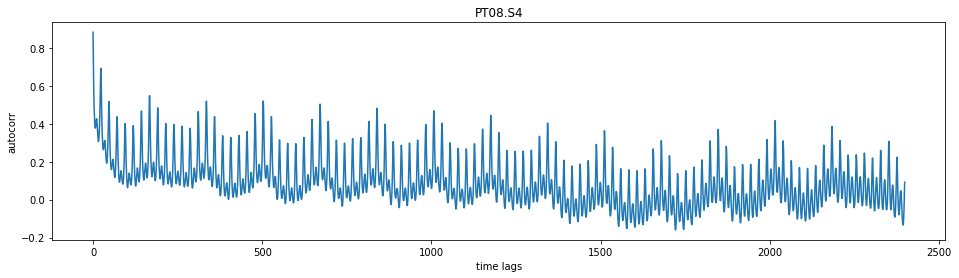

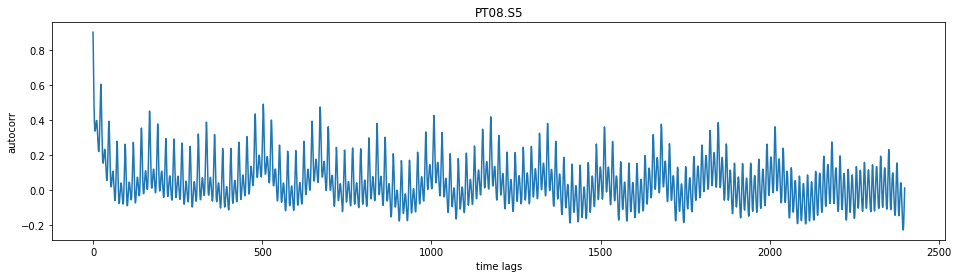

In [9]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [10]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(1,100)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|██████████| 99/99 [00:42<00:00,  2.35it/s]

BEST ORDER: 27 BEST AIC: 48.273793081697974


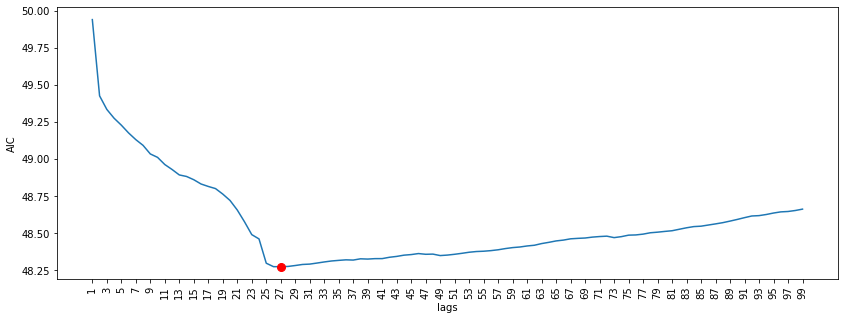

In [11]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [12]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

48.273793081697974

# COMBINE VAR AND LSTM

In [13]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###


def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):
    
    set_seed(33)
    
    opt = Adam()
    opt.lr = param['lr']
        
    inp = Input(shape=(look_back, 18))
    
    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='tanh', 
             return_sequences=True)(x)
    out = TimeDistributed(Dense(9))(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model


def get_model_finetune(param, kgs, look_ahead, look_back):
    
    set_seed(33)
    
    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())
    
    best_model_config.optimizer.lr = param['lr']
    
    return best_model_config

In [14]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [128, 96, 64], 
    'lr': [7e-4, 1e-3, 3e-3], 
    'epochs': 200, 
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025), 
    'epochs': 200, 
}

In [15]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = var_result.fittedvalues

X_train = np.concatenate([
    train.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([
    var_result.fittedvalues, train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(
    X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = np.concatenate([test.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(5966, 18) (1492, 18) (1872, 18)
(5966, 18) (1492, 18)
(5966, 9) (1492, 9) (1872, 9)
(5966, 9) (1492, 9)


In [16]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [17]:
### BUILD DATA GENERATOR ###

look_back = 24*2
look_ahead = 6

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)

X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(5913, 48, 18) (1439, 48, 18) (1819, 48, 18)
(5913, 48, 18) (1439, 48, 18)
(5913, 6, 9) (1439, 6, 9) (1819, 6, 9)
(5913, 6, 9) (1439, 6, 9)


In [18]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs_var = KerasGridSearch(hypermodel, param_grid, 
                          monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.97978 at epoch 7

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.99235 at epoch 14

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.91942 at epoch 3

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.98453 at epoch 7

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.96477 at epoch 7

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.01436 at epoch 13

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.00705 at epoch 10

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, '

In [19]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)  

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'], 
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 0.9627 at epoch 1

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 0.95952 at epoch 1

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 0.91611 at epoch 1

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 0.94841 at epoch 1

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 0.92288 at epoch 1

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 0.91567 at epoch 1

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 0.95173 at epoch 1

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 0.91128 at epoch 1

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 0.91139 at epoch 1

***** (10/20) *****
Search({'lr': 9.772977050450925e-05, 'epochs': 

In [20]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)

In [21]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs = KerasGridSearch(hypermodel, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.97978 at epoch 7

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.99235 at epoch 14

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.91942 at epoch 3

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.98453 at epoch 7

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.96477 at epoch 7

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.01436 at epoch 13

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.00705 at epoch 10

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, '

In [22]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)

In [23]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = np.sqrt(error)

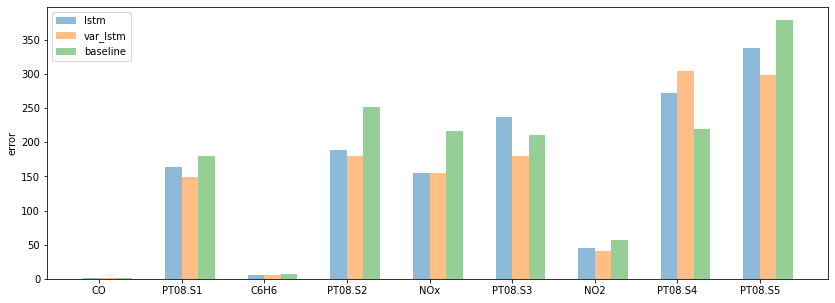

In [24]:
### COMPARE RESULTS ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(error_lstm))-0.1, error_lstm.values(), 
        alpha=0.5, width=0.2, label='lstm')
plt.bar(np.arange(len(error_var_lstm))+0.1, error_var_lstm.values(), 
        alpha=0.5, width=0.2, label='var_lstm')
plt.bar(np.arange(len(error_baseline))+0.3, error_baseline.values(), 
        alpha=0.5, width=0.2, label='baseline')
plt.xticks(range(len(error_lstm)), error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)